### Import Some Basic Things

In [63]:
# Import Necessary Addons
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os, os.path # Get directory info

# Get the list of all files in the directory
DIR = './camera_cal/'
image_names = [name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]

nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y
images = []
grays = []
imgpoints = []
objpoints = []

objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

### Read in all Calibration Images and Display them

./camera_cal/calibration15.jpg
./camera_cal/calibration19.jpg
./camera_cal/calibration11.jpg
./camera_cal/calibration17.jpg
./camera_cal/calibration10.jpg
./camera_cal/calibration1.jpg
./camera_cal/calibration2.jpg
./camera_cal/calibration8.jpg
./camera_cal/calibration5.jpg
./camera_cal/calibration20.jpg
./camera_cal/calibration18.jpg
./camera_cal/calibration9.jpg
./camera_cal/calibration12.jpg
./camera_cal/calibration6.jpg
./camera_cal/calibration3.jpg
./camera_cal/calibration14.jpg
./camera_cal/calibration4.jpg
./camera_cal/calibration13.jpg
./camera_cal/calibration16.jpg
./camera_cal/calibration7.jpg


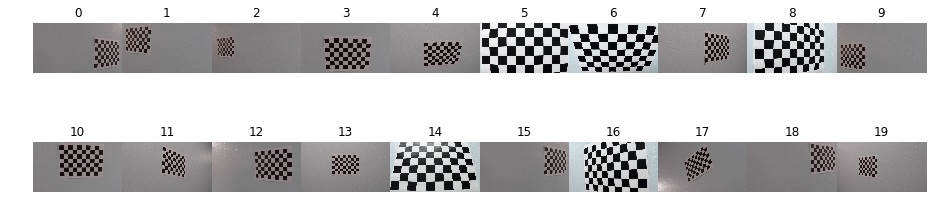

In [64]:
# Read in all images
for i in range (len(image_names)):
    filename = DIR + image_names[i]
    image = cv2.imread(DIR + image_names[i])
    images.append(image)
    grays.append(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
    ret, corners = cv2.findChessboardCorners(grays[i], (nx, ny), None)

    
    # Add points if corners are detected
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

    print(filename)

    
# Set up subplot details
fig, axs = plt.subplots(2,10, figsize=(16, 4))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Plot all of the Calibration Images
for i in range(20):
    image = images[i]
    axs[i].axis('off')
    axs[i].imshow(image, cmap='gray')
    axs[i].set_title(i)
plt.show()

### Define Undistort Function, get Camera Matrix and print some test images

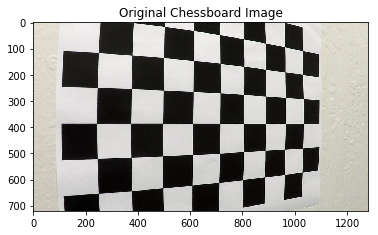

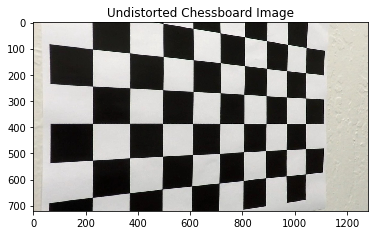

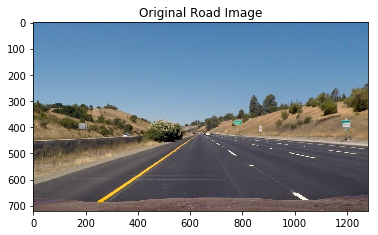

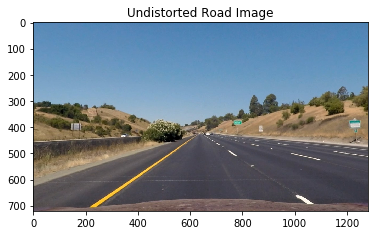

In [65]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, grays[2].shape[::-1], None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst


# Original Chessboard
plt.imshow(cv2.cvtColor(images[8], cv2.COLOR_BGR2RGB))
plt.title("Original Chessboard Image")
plt.show()

# Undistorted Chessboard
undistorted_chess = cal_undistort(images[8], objpoints, imgpoints)
plt.imshow(cv2.cvtColor(undistorted_chess, cv2.COLOR_BGR2RGB))
plt.title("Undistorted Chessboard Image")
plt.show()

# Original Road
original_road = cv2.imread('./test_images/straight_lines1.jpg')
plt.imshow(cv2.cvtColor(original_road, cv2.COLOR_BGR2RGB))
plt.title("Original Road Image")
plt.show()

# Undistorted Road
undistorted_road = cal_undistort(original_road, objpoints, imgpoints)
plt.imshow(cv2.cvtColor(undistorted_road, cv2.COLOR_BGR2RGB))
plt.title("Undistorted Road Image")
plt.show()

### Use Color Transforms, Gradients, Thresholds, etc... to get a Good Binary Image

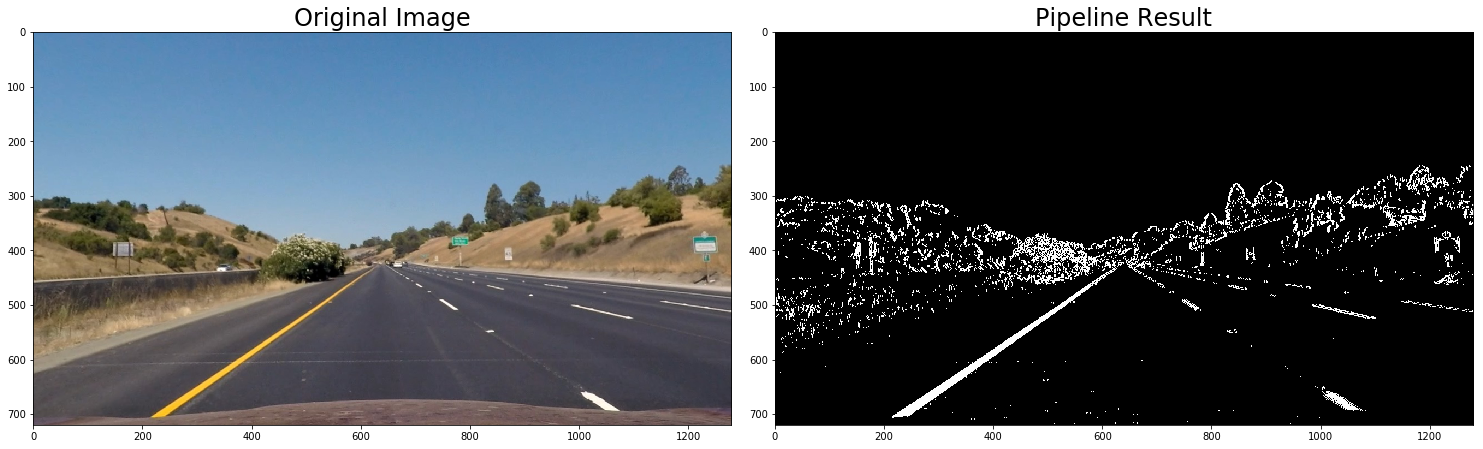

In [66]:
# Make a copy of the undistorted road test image
image = np.copy(undistorted_road)

# Function for converting BGR images to binary
def binaryImage(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    
    # Convert to HLS color space and separate the V channel
    img = np.copy(img)
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary



binary_image = binaryImage(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
f.tight_layout()

ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=24)

ax2.imshow(binary_image, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=24)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.show()

### Draw Lines to be used for Perspective Transform

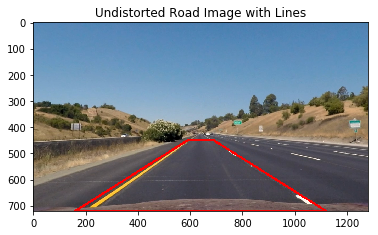

In [74]:
lined_image = np.copy(image)
lined_image = cv2.cvtColor(lined_image, cv2.COLOR_BGR2RGB)

# Draw the source points

# Source region attributes
bottom_left   = (160, 720)
top_left      = (590, 450)
top_right     = (690, 450)
bottom_right  = (1120, 720)
lineThickness = 7
line_color    = (255, 0, 0)

# Left line
cv2.line(lined_image, bottom_left, top_left, line_color, lineThickness)
# Right line
cv2.line(lined_image, bottom_right, top_right, line_color, lineThickness)
# Bottom line
cv2.line(lined_image, bottom_left, bottom_right, line_color, lineThickness)
# Top line
cv2.line(lined_image, top_left, top_right, line_color, lineThickness)


plt.imshow(lined_image, cmap='gray')
plt.title("Undistorted Road Image with Lines")
plt.show()

### Perform Perspective Transform to "bird's eye view" of Lanes

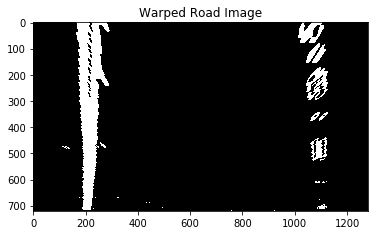

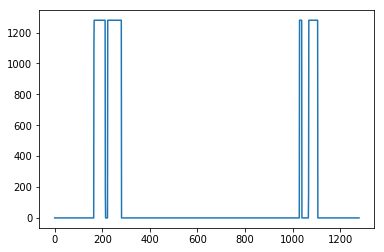

In [88]:


road_src_points = np.array([list(bottom_left), list(top_left), list(top_right), list(bottom_right)],np.float32) # Points at the start

point1 = list(bottom_left)

point2 = [bottom_left[0]]
point2.append(0)

point3 = [bottom_right[0]]
point3.append(0)

point4 = list(bottom_right)

#x = np.array([2,3,1,0])
road_dst_points = np.array([point1, point2, point3, point4],np.float32) # Points after transform

#print(road_src_points)
#print(road_dst_points)

warped_road = np.copy(image)

img_size = (image.shape[1], image.shape[0])
M = cv2.getPerspectiveTransform(road_src_points, road_dst_points)
# Warp the image using OpenCV warpPerspective()
warped_road = cv2.warpPerspective(binary_image, M, img_size)

# Bird's Eye Road
plt.imshow(warped_road, cmap='gray')
plt.title("Warped Road Image")
plt.show()

# Plot Histogram
histogram = np.sum(warped_road[warped_road[0],:], axis=0)
plt.plot(histogram)
plt.show()